# Performing NNSIM on the 2D Flume Case

The auxiliary variable is not taken into account

Jan. 24, 2022

In [1]:
# import necessary package
import matplotlib.pyplot as plt
import numpy as np

import time

from PIL import Image

from scipy.spatial import distance
from scipy.stats import entropy

from sklearn.decomposition import PCA


from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

from tqdm import tqdm

from scipy import ndimage

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# !pip install -U scikit-learn
# import sklearn
# print(sklearn.__version__)

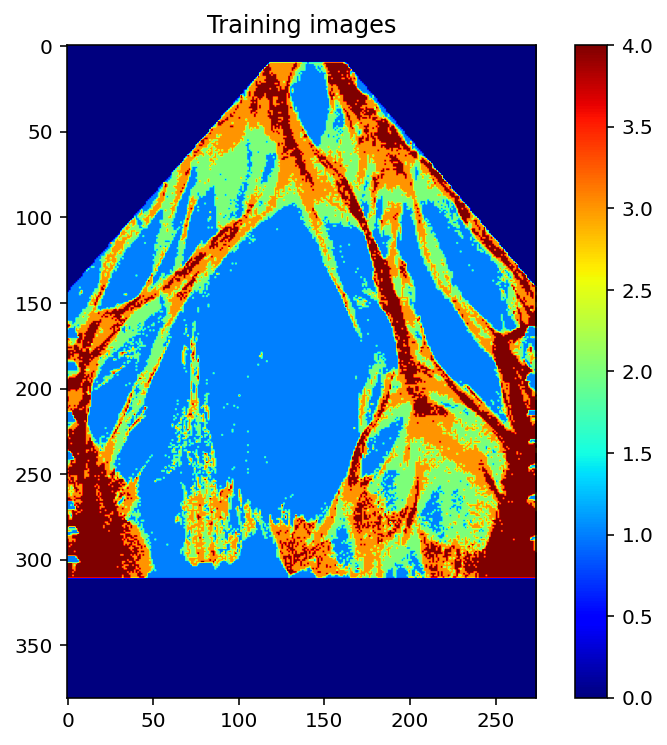

In [3]:
TI_Height = 381
TI_Width = 274

TrainingImage = np.loadtxt(fname='FlumeData_TrainingImage_4Categories.txt',
                  dtype=int,
                  delimiter=',').reshape((TI_Height,TI_Width))

plt.figure(figsize=(7,6))
plt.imshow(TrainingImage,cmap='jet')
plt.title(f'Training images')
plt.colorbar()
plt.show()

In [4]:
# read the mask image

FlumeImage_Mask = np.loadtxt(fname='FlumeData_Mask.txt',
                  dtype=int,
                  delimiter=',').reshape((TI_Height,TI_Width))

In [5]:
def TemplatePointSequence(template_radius_y,
                          template_radius_x,
                          grid_factor):
    '''determine the sequence about how to create a pattern'''
    
    sequence_y = []
    sequence_x = []
    sequence_distance = []
    
    for point_y in range(-template_radius_y,template_radius_y+1):
        for point_x in range(-template_radius_x,template_radius_x+1):
            sequence_y.append(point_y*grid_factor)
            sequence_x.append(point_x*grid_factor)
            sequence_distance.append(np.sqrt(point_y*point_y+point_x*point_x))
    
    sequence_y = np.array(sequence_y).astype(int)
    sequence_x = np.array(sequence_x).astype(int)
    sequence_distance = np.array(sequence_distance)
            
    rank = np.argsort(sequence_distance)
    
    sequence_y = sequence_y[rank]
    sequence_x = sequence_x[rank]
    
    sequence_y = np.delete(arr=sequence_y,obj=0)
    sequence_x = np.delete(arr=sequence_x,obj=0)
       
    return sequence_y.tolist(), sequence_x.tolist()

In [6]:
def ExtractPattern_Training(domain2D_list,
                            center_y,center_x,
                            sequence_y,sequence_x):
    
    '''extract a pattern from training image based on a given location'''
    
    pattern = []
    for relative_y, relative_x in zip(sequence_y,sequence_x):
        pattern.append(domain2D_list[center_y+relative_y][center_x+relative_x])
    return np.array(pattern)

In [7]:
def ExtractPattern_Simulation(domain2D_list,
                              domain_height,domain_width,
                              center_y,center_x,
                              sequence_y,sequence_x,
                              unknownSymbol):
    
    '''extract a pattern from simulation grid based on a given location'''
    
    
    pattern = []
    for relative_y, relative_x in zip(sequence_y,sequence_x):
        point_y = center_y + relative_y
        point_x = center_x + relative_x
        if(point_y>=0 and point_y<domain_height and point_x>=0 and point_x<domain_width):
            pattern.append(domain2D_list[point_y][point_x])
        else:
            pattern.append(unknownSymbol)
    pattern = np.array(pattern)
    knownAmount = np.argwhere(pattern != unknownSymbol).shape[0]
    return pattern, knownAmount

In [8]:
def ExtractPattern_Simulation(domain2D_list,
                              domain_height,domain_width,
                              center_y,center_x,
                              sequence_y,sequence_x,
                              unknownSymbol):
    
    '''extract a pattern from simulation grid based on a given location'''
    
    
    pattern = []
    for relative_y, relative_x in zip(sequence_y,sequence_x):
        point_y = center_y + relative_y
        point_x = center_x + relative_x
        if(point_y>=0 and point_y<domain_height and point_x>=0 and point_x<domain_width):
            pattern.append(domain2D_list[point_y][point_x])
        else:
            pattern.append(unknownSymbol)
    pattern = np.array(pattern)
    knownAmount = np.argwhere(pattern != unknownSymbol).shape[0]
    return pattern, knownAmount

In [9]:
def ExtractPattern_Simulation_Magnet(domain2D_list,
                                     domain_height,
                                     domain_width,
                                     center_y,
                                     center_x,
                                     template_knn,
                                     template_radius_y,
                                     template_radius_x,
                                     template_size,
                                     unknownSymbol,
                                     uninterestedSymbol):
    
    '''extract a pattern from simulation grid based on a given location'''
    
    searching_location = []
    searching_value = []
    for relative_y in range(-template_radius_y,template_radius_y+1):
        for relative_x in range(-template_radius_x, template_radius_x+1):
            point_y = center_y + relative_y
            point_x = center_x + relative_x
            
            if(point_y>=0 and point_y<domain_height and point_x>=0 and point_x<domain_width):
                if(domain2D_list[point_y][point_x] != unknownSymbol and
                   domain2D_list[point_y][point_x] != uninterestedSymbol):
                    
                    searching_value.append(domain2D_list[point_y][point_x])
                    searching_location.append(relative_y)
                    searching_location.append(relative_x)
            
    searching_location = np.array(searching_location).reshape((-1,2))
    
    if(searching_location.shape[0] == 0):
        return np.array([0]), 0
    
    neigh_dist, neigh_index  = template_knn.kneighbors(X = searching_location)
    neigh_dist = neigh_dist.reshape(-1)
    neigh_index = neigh_index.reshape(-1)
    
    pattern = [unknownSymbol] * template_size
    magnet_dist = [999999] * template_size
    
    for dist, index, value in zip(neigh_dist, neigh_index, searching_value):
        if(pattern[index] == unknownSymbol):
            pattern[index] = value
            magnet_dist[index] = dist
        elif(magnet_dist[index] > dist):
            pattern[index] = value
            magnet_dist[index] = dist
            
    knownAmount = np.argwhere(pattern != unknownSymbol).shape[0]

    return np.array(pattern), knownAmount

In [10]:
def EncodePattern_OneHotEncoding(pattern_input,patternSize,faciesAmount):
    
    '''convert pattern using one-hot encoding'''
    '''Important warning pattern: original pattern  vector: pattern after one-hot encoding'''
    
    pattern_output = np.zeros((patternSize,faciesAmount))
    
    for index, element in enumerate(pattern_input):
        if(element >= 0):
            pattern_output[index,int(element-1)] = 1.0
        
    pattern_output = pattern_output.reshape(-1)
    
    return pattern_output

In [11]:
def ConstructPatternBase_Multigrid(TI_list,
                                   TI_Height,TI_Width,
                                   sequence_y, sequence_x,
                                   template_radius_y,template_radius_x, 
                                   grid_factor, 
                                   uninterestedSymbol):
    
    '''construct pattern database within the multi-grid framework'''
    
    # the dimension of pattern
    patternSize = len(sequence_y)   
    
    PatternBase = []
    Pattern_label = []
    
    for center_y in range(grid_factor*template_radius_y,TI_Height-grid_factor*template_radius_y): 
        for center_x in range(grid_factor*template_radius_x,TI_Width-grid_factor*template_radius_x): 
            # extract a pattern
            pattern = ExtractPattern_Training(domain2D_list=TI_list,
                                              center_y=center_y,center_x=center_x,
                                              sequence_y=sequence_y,sequence_x=sequence_x)
            if(np.argwhere(pattern == uninterestedSymbol).shape[0] != 0):
                '''there is unknown points in this pattern'''
                continue
            
            # store primary pattern in database
            PatternBase.extend(pattern.tolist())
            Pattern_label.append(TI_list[center_y][center_x])
            
    PatternBase = np.array(PatternBase).astype(int)
    PatternBase = PatternBase.reshape((-1,patternSize))
            
    return PatternBase, np.array(Pattern_label)

In [12]:
def Fast_condensed_nearest_neighbor(Dataset,
                                    Dataset_labels,
                                    facies_amount):
    
    '''carry out fast condensed nearest neighbor (FCNN) to remove noisy patterns'''
    
    Num_neighbors = 3
    FCNN_Iteration_Max = 30
    
    
    # find the centroids
    # centroid is the mean value
    Centroids = []
    for index_label in range(1, facies_amount+1):
        centroids = np.median(Dataset[ Dataset_labels == index_label ],axis=0).tolist()
        Centroids.extend(centroids)
    
    Centroids = np.array(Centroids).reshape((facies_amount,-1))


    knn_instance = NearestNeighbors(n_neighbors = 1,
                                        algorithm = 'ball_tree',
                                        metric = 'hamming')

    knn_instance.fit(X=Dataset)
    
    neighbors_distance, neighbors_index = knn_instance.kneighbors(X=Centroids)
    
    S_indices = np.copy(neighbors_index).reshape(-1)
    S = np.copy(Dataset[S_indices])
    
    
    iteration_index = 0
    
    Dataset_element_num = Dataset.shape[0]
    
    knn_classifier_instance = KNeighborsClassifier(n_neighbors = 1,
                                                      algorithm = 'auto',
                                                      metric = 'hamming',
                                                      n_jobs = 6)
    
    
    # The only one purpose of PCA is to visulize the FCNN process
 
    pca = PCA(n_components=2)
    pca.fit(Dataset)    
    Dataset_decomposed = pca.transform(Dataset)[:,0:2]
    
    for iteration_index in tqdm(range(FCNN_Iteration_Max)):
        
        if(S_indices.shape[0] < Num_neighbors):
            knn_classifier_instance = KNeighborsClassifier(n_neighbors = 1,
                                                      algorithm = 'auto',
                                                      metric = 'hamming',
                                                      n_jobs = 6)
        else:
            knn_classifier_instance = KNeighborsClassifier(n_neighbors = Num_neighbors,
                                                      algorithm = 'auto',
                                                      metric = 'hamming',
                                                      n_jobs = 6)
        
        T_indices = np.setdiff1d(np.arange(0,Dataset_element_num,1), S_indices)
        T = np.copy(Dataset[T_indices])
        
        knn_classifier_instance.fit(X = S, y=Dataset_labels[S_indices])
        
        labels_predict = knn_classifier_instance.predict(X = T)
        
        difference = Dataset_labels[T_indices] - labels_predict
        
        misclassified_indices = np.argwhere( difference != 0.0  ).reshape(-1)
        
        
        if(misclassified_indices.shape[0] == 0):
            break
        
        neighbor_distance, misclassified_medoid_indices = knn_classifier_instance.kneighbors(X = T[misclassified_indices])
        misclassified_medoid_indices = np.unique(misclassified_medoid_indices)
        
        knn_instance.fit(X = T[misclassified_indices])
        
        neighbors_distance, representative_indices = knn_instance.kneighbors(X = S[misclassified_medoid_indices])
        representative_indices = representative_indices.reshape(-1)
        alpha_S_indices = T_indices[misclassified_indices[representative_indices]].reshape(-1)
        
        S_indices = np.concatenate((S_indices, alpha_S_indices))
        S_indices = np.unique(S_indices)
        
        S = np.copy(Dataset[S_indices])
        
#         print(f'The number of prototype patterns is {S.shape[0]}')

#         plt.scatter(Dataset_decomposed[:,0], Dataset_decomposed[:,1],
#                     c=Dataset_labels, cmap='Greens',
#                     s=20, lw=0,
#                     vmin=-1, vmax=2)
#         plt.scatter(Dataset_decomposed[S_indices,0], Dataset_decomposed[S_indices,1],
#                     c='r',
#                     s=30, lw=0)
#         plt.scatter(Dataset_decomposed[alpha_S_indices,0], Dataset_decomposed[alpha_S_indices,1],
#                     c='b',
#                     s=20, lw=0)
#         plt.xlabel(str('PC1'),fontsize='large')
#         plt.ylabel(str('PC2'),fontsize='large')
#         plt.tick_params(direction='in',labelsize='large')
#         plt.title(f'Iteration {iteration_index} with {S.shape[0]} patterns')
#         plt.show()
        
#         print(f'S indices: {S_indices}')
#         print(f'S labels: {Dataset_labels[S_indices]}')
    
    return np.copy(S_indices)

In [13]:
def ConstructPatternBase_Multigrid_FCNN(Dataset,
                                          Dataset_labels,
                                          facies_amount):
    
    print(f'Carrying out fast condensed nearest neighbor')
    
    Dataset_resampled_indices = Fast_condensed_nearest_neighbor(Dataset = Dataset,
                                                                Dataset_labels = Dataset_labels,
                                                                facies_amount = facies_amount)

    print(f'The number of patterns before FCNN {Dataset.shape[0]}')
    print(f'The number of patterns after  FCNN {Dataset_resampled_indices.shape}')
    
    return Dataset_resampled_indices

In [14]:
def RandomSimulationPath(grid_factor,
                         mask_image,
                         uninterestedSymbol):
    '''define the simulation path within the multi-grid framework'''
    
    mask_image_grid = np.copy(mask_image[::grid_factor,::grid_factor])
    unknownPoint = np.argwhere(mask_image_grid != uninterestedSymbol).reshape((-1,2))
    unknownPoint = unknownPoint * grid_factor
    
    simulationPath = np.arange(0,unknownPoint.shape[0],1)
    np.random.shuffle(simulationPath)
    
    simulationPath_y = unknownPoint[simulationPath,0]
    simulationPath_x = unknownPoint[simulationPath,1]
    
    return simulationPath_y.astype(int).tolist(), simulationPath_x.astype(int).tolist()

In [15]:
def InitializeRealization2D_unconditional(domain_height,
                                          domain_width,
                                          mask_image,
                                          sampleRate,
                                          faciesAmount,
                                          unknownSymbol,
                                          uninterestedSymbol):
    
    '''initialize a realization'''
    
    sampleAmount = int(domain_height*domain_width*sampleRate)
    
    hardDataPath = np.arange(domain_height*domain_width)
    np.random.shuffle(hardDataPath)
    hardDataPath = hardDataPath[:sampleAmount]
    hardDataPath_y = hardDataPath // domain_width
    hardDataPath_x = hardDataPath % domain_width
    
    hardDataValue = np.random.randint(low=1,high=faciesAmount+1,size=sampleAmount)
    
    Realization2D = np.full(shape=(domain_height,domain_width), fill_value=unknownSymbol)
    
    for center_y, center_x, value in zip(hardDataPath_y, hardDataPath_x, hardDataValue):
        Realization2D[center_y, center_x] = value
    
    Realization2D[ mask_image==uninterestedSymbol ] = uninterestedSymbol
    
    return Realization2D

In [16]:
def InitializeRealization2D_conditional(domain_height,
                                          domain_width,
                                          TrainingImage_list,
                                          mask_image,
                                          sampleRate,
                                          faciesAmount,
                                          unknownSymbol,
                                          uninterestedSymbol):
    
    '''initialize a realization'''
    
    sampleAmount = int(domain_height*domain_width*sampleRate)
    
    hardDataPath = np.arange(domain_height*domain_width)
    np.random.shuffle(hardDataPath)
    hardDataPath = hardDataPath[:sampleAmount]
    hardDataPath_y = hardDataPath // domain_width
    hardDataPath_x = hardDataPath % domain_width
    
    Realization2D = np.full(shape=(domain_height,domain_width), fill_value=unknownSymbol)
    
    for center_y, center_x in zip(hardDataPath_y, hardDataPath_x):
        value = TrainingImage_list[center_y][center_x]
        Realization2D[center_y, center_x] = value
    
    Realization2D[ mask_image==uninterestedSymbol ] = uninterestedSymbol
    
    return Realization2D

In [17]:
def Simulate_Realizations_BallTree_TeacherStudent(TrainingImage,
                                     TrainingImage_list,
                                     TI_Height,
                                     TI_Width,
                                     SG_Mask,
                                     SG_Amount,
                                     SG_Height,
                                     SG_Width,
                                     MultiGrid,
                                     Template_radius_y,
                                     Template_radius_x,
                                     Num_neighbors_searching,
                                     Num_neighbors_thresholding,
                                     FaciesAmount,
                                     UnknownSymbol,
                                     UninterestedSymbol,
                                     SG_Amount_teacher,
                                     Divergence_Threshold):
    
    print('\n\n\nFCNN selection, Teacher student improvement, and Ball tree searching')
    
    # unconditional simulation
    RealizationSet = []
    for index_realization in range(SG_Amount):    
#         SimulationGrid = InitializeRealization2D_unconditional(domain_height = SG_Height,
#                                                                domain_width = SG_Width,
#                                                                sampleRate = 0.01,
#                                                                mask_image = SG_Mask,
#                                                                faciesAmount = FaciesAmount,
#                                                                unknownSymbol = UnknownSymbol,
#                                                                uninterestedSymbol = UninterestedSymbol)
        
        SimulationGrid = InitializeRealization2D_conditional(domain_height = SG_Height,
                                                              domain_width = SG_Width,
                                                              TrainingImage_list = TrainingImage_list,
                                                              mask_image = SG_Mask,
                                                              sampleRate = 0.05,
                                                              faciesAmount = FaciesAmount,
                                                              unknownSymbol = UnknownSymbol,
                                                              uninterestedSymbol = UninterestedSymbol)
        RealizationSet.extend(SimulationGrid.tolist())
        
    RealizationSet = np.array(RealizationSet)
    RealizationSet = RealizationSet.reshape((SG_Amount, SG_Height, SG_Width))
    
    # multigrid strategy
    for grid in np.arange(start=MultiGrid, stop=-1, step=-1):
        
        print(f'Grid {grid}:')
        
        starting_time = time.time()
        
        grid_factor = 2**grid
        
        # define the sequence to collect hard data
        sequence_y, sequence_x = TemplatePointSequence(template_radius_y=Template_radius_y,
                                                  template_radius_x=Template_radius_x,
                                                  grid_factor=grid_factor)
        pattern_size = len(sequence_y)
        
        template_location = np.concatenate((np.array(sequence_y).reshape(-1,1),np.array(sequence_x).reshape(-1,1)),axis=1)
        template_knn = NearestNeighbors(n_neighbors = 1,
                                        algorithm = 'ball_tree',
                                        metric='euclidean')
        template_knn.fit(template_location)
        
        
        # construct a pattern dataset
        Dataset, Labels = ConstructPatternBase_Multigrid(TI_list = TrainingImage_list,
                                                                  TI_Height = TI_Height,
                                                                  TI_Width = TI_Width,
                                                                  sequence_y = sequence_y,
                                                                  sequence_x = sequence_x,
                                                                  template_radius_y = Template_radius_y,
                                                                  template_radius_x= Template_radius_x, 
                                                                  grid_factor = grid_factor, 
                                                                  uninterestedSymbol = UninterestedSymbol)
        
        Labels = Labels.astype(int)
        
        FCNN_resample_indices = ConstructPatternBase_Multigrid_FCNN(Dataset = Dataset,
                                                                    Dataset_labels = Labels,
                                                                    facies_amount = FaciesAmount)

        Student_resample_indices = np.copy(FCNN_resample_indices).tolist()
        
        
        ball_tree_teacher = NearestNeighbors(n_neighbors = Num_neighbors_searching,
                                    algorithm = 'ball_tree',
                                    metric='hamming')
        ball_tree_teacher.fit(Dataset)
        
        ball_tree_student = NearestNeighbors(n_neighbors = Num_neighbors_searching,
                                            algorithm = 'ball_tree',
                                            metric='hamming')        
        ending_time = time.time()
        print(f'The FCNN program costs {ending_time-starting_time} seconds')
        
        # teaching step
        print('Teacher simulation')
        for index_realization in tqdm(range(SG_Amount_teacher)):
#         for index_realization in range(SG_Amount_teacher):
#             print(f'Teacher realization #{index_realization}')
            
            # get initial realization
            Realization2D_list = np.copy(RealizationSet[index_realization]).tolist()
                      
            # update student ball tree
            Dataset_student = np.copy(Dataset[Student_resample_indices])
            Labels_student = np.copy(Labels[Student_resample_indices])
            ball_tree_student.fit(Dataset_student)
            print(f'The shape of student set is {Dataset_student.shape}')
            
            # define a random simulation path
            simulationPath_y_list, simulationPath_x_list = RandomSimulationPath(grid_factor = grid_factor,
                                                                      mask_image = SG_Mask,
                                                                      uninterestedSymbol = UninterestedSymbol)
            
#             for index_point in tqdm(range(len(simulationPath_y_list))):
#                 unknown_y = simulationPath_y_list[index_point]
#                 unknown_x = simulationPath_x_list[index_point]
            
            for unknown_y, unknown_x in zip(simulationPath_y_list, simulationPath_x_list):
                
                if(Realization2D_list[unknown_y][unknown_x]!=UnknownSymbol):
                    continue
                    
                # find an unknown point
                
                if(grid == 0):
                    conditioningPattern, knownAmount = ExtractPattern_Simulation(domain2D_list = Realization2D_list,
                                                                                  domain_height = SG_Height,
                                                                                  domain_width = SG_Width,
                                                                                  center_y = unknown_y,
                                                                                  center_x = unknown_x,
                                                                                  sequence_y = sequence_y,
                                                                                  sequence_x = sequence_x,
                                                                                  unknownSymbol = UnknownSymbol)
                else:
                    conditioningPattern, knownAmount = ExtractPattern_Simulation_Magnet(domain2D_list = Realization2D_list,
                                                                                  domain_height = SG_Height,
                                                                                  domain_width = SG_Width,
                                                                                  center_y = unknown_y,
                                                                                  center_x = unknown_x,
                                                                                  template_knn = template_knn,
                                                                                  template_radius_y = Template_radius_y * grid_factor,
                                                                                  template_radius_x = Template_radius_x * grid_factor,
                                                                                  template_size = pattern_size,
                                                                                  unknownSymbol = UnknownSymbol,
                                                                                  uninterestedSymbol = UninterestedSymbol)
                
                if(knownAmount == 0):
                    # the conditioning pattern does not have known point
                    # randomly assign a value to the simulating point
                    unknown_value = int(np.random.randint(low=1,high=FaciesAmount+1,size=1))
                else:
                    # perform a ball tree search to find comparable pattern
                    conditioningPattern = conditioningPattern.reshape((1,-1))
                    
                    # teacher finding
                    patternDistance, similarityIndex = ball_tree_teacher.kneighbors(conditioningPattern)
                    patternDistance = patternDistance.reshape(-1)
                    similarityIndex_teacher = similarityIndex.reshape(-1)
                    
                    distance_threshold = patternDistance[Num_neighbors_thresholding]
                    similarityIndex_teacher = similarityIndex_teacher[ patternDistance <= distance_threshold ]

                    occurrence_teacher = np.bincount(Labels[similarityIndex_teacher],minlength=FaciesAmount+1)
                    
                    # simulate the unknown point according to the teacher finding
                    unknown_value = int(np.random.choice(a=Labels[similarityIndex_teacher],size=1)[0])
                    
                    # student finding
                    patternDistance, similarityIndex = ball_tree_student.kneighbors(conditioningPattern)   
                    patternDistance = patternDistance.reshape(-1)
                    similarityIndex_student = similarityIndex.reshape(-1)
                    
                    distance_threshold = patternDistance[Num_neighbors_thresholding]
                    similarityIndex_student = similarityIndex_student[ patternDistance <= distance_threshold ]
                    
                    occurrence_student = np.bincount(Labels_student[similarityIndex_student],minlength=FaciesAmount+1)
                    
                    # compare teacher and student's performance                    
                    # cosine distance
                    divergence = distance.cosine(occurrence_teacher, occurrence_student)
                    
                    if(divergence > Divergence_Threshold):
                        # student cannot address this conditioning pattern
                        Student_resample_indices.extend(similarityIndex_teacher.tolist())
                    
                Realization2D_list[unknown_y][unknown_x] = unknown_value
            
            # store the simulated result
            RealizationSet[index_realization] = np.copy(np.array(Realization2D_list))
            
            # remove redundant element
            Student_resample_indices = np.unique(Student_resample_indices).tolist()
            print(f'The number of student set is {len(Student_resample_indices)}')
        
        
        # update student ball tree
        Dataset_student = np.copy(Dataset[Student_resample_indices])
        Labels_student = np.copy(Labels[Student_resample_indices])
        ball_tree_student.fit(Dataset_student)
        print(f'The shape of student set is {Dataset_student.shape}')
            
        print('Student simulation')
        for index_realization in tqdm(range(SG_Amount_teacher, SG_Amount)):
            
#             print(f'Student Realization {index_realization}')
            
            Realization2D_list = np.copy(RealizationSet[index_realization]).tolist()
            
            # define a random simulation path
            simulationPath_y_list, simulationPath_x_list = RandomSimulationPath(grid_factor = grid_factor,
                                                                      mask_image = SG_Mask,
                                                                      uninterestedSymbol = UninterestedSymbol)
            
            for unknown_y, unknown_x in zip(simulationPath_y_list, simulationPath_x_list):
                
                if(Realization2D_list[unknown_y][unknown_x]!=UnknownSymbol):
                    continue
                    
                # find an unknown point
                if(grid == 0):
                    conditioningPattern, knownAmount = ExtractPattern_Simulation(domain2D_list = Realization2D_list,
                                                                                  domain_height = SG_Height,
                                                                                  domain_width = SG_Width,
                                                                                  center_y = unknown_y,
                                                                                  center_x = unknown_x,
                                                                                  sequence_y = sequence_y,
                                                                                  sequence_x = sequence_x,
                                                                                  unknownSymbol = UnknownSymbol)
                else:
                    conditioningPattern, knownAmount = ExtractPattern_Simulation_Magnet(domain2D_list = Realization2D_list,
                                                                                  domain_height = SG_Height,
                                                                                  domain_width = SG_Width,
                                                                                  center_y = unknown_y,
                                                                                  center_x = unknown_x,
                                                                                  template_knn = template_knn,
                                                                                  template_radius_y = Template_radius_y * grid_factor,
                                                                                  template_radius_x = Template_radius_x * grid_factor,
                                                                                  template_size = pattern_size,
                                                                                  unknownSymbol = UnknownSymbol,
                                                                                  uninterestedSymbol = UninterestedSymbol)
                
                if(knownAmount == 0):
                    # the conditioning pattern does not have known point
                    # randomly assign a value to the simulating point
                    unknown_value = int(np.random.randint(low=1,high=FaciesAmount+1,size=1))
                else:
                    # perform a ball tree search to find comparable pattern
                    conditioningPattern = conditioningPattern.reshape((1,-1))
                    
                    patternDistance, similarityIndex = ball_tree_student.kneighbors(conditioningPattern)
                    patternDistance = patternDistance.reshape(-1)
                    similarityIndex = similarityIndex.reshape(-1)
                    
                    distance_threshold = patternDistance[Num_neighbors_thresholding]
                    similarityIndex = similarityIndex[ patternDistance <= distance_threshold ]
                    
                    unknown_value = int(np.random.choice(a=Labels_student[similarityIndex],size=1)[0])
                    
                Realization2D_list[unknown_y][unknown_x] = unknown_value
            
            RealizationSet[index_realization] = np.copy(np.array(Realization2D_list))
            
    return RealizationSet

In [18]:
MultiGrid = 3

Template_radius_y = 3
Template_radius_x = 3

SimulationGrid_Num = 10
SimulationGrid_Height = TI_Height
SimualtionGrid_Width = TI_Width

Num_neighbors_searching = 213
Num_neighbors_threshold = 0

Facies_Amount = 4

Uninterested_Symbol = 0
Unknown_Symbol = -1

SG_Amount_teacher = min(4,SimulationGrid_Num)
Divergence_Threshold = 0.1

In [19]:
starting_time = time.time()
Realizations_FCNN_BallTree_TeacherStudent = Simulate_Realizations_BallTree_TeacherStudent(TrainingImage = TrainingImage,
                                     TrainingImage_list = TrainingImage.tolist(),
                                     TI_Height = TI_Height,
                                     TI_Width = TI_Width,
                                     SG_Mask = FlumeImage_Mask,
                                     SG_Amount = SimulationGrid_Num,
                                     SG_Height = SimulationGrid_Height,
                                     SG_Width = SimualtionGrid_Width,
                                     MultiGrid = MultiGrid,
                                     Template_radius_y = Template_radius_y,
                                     Template_radius_x = Template_radius_x,                                          
                                     Num_neighbors_searching = Num_neighbors_searching,
                                     Num_neighbors_thresholding = Num_neighbors_threshold,
                                     FaciesAmount = Facies_Amount,
                                     UnknownSymbol = Unknown_Symbol,
                                     UninterestedSymbol = Uninterested_Symbol,
                                     SG_Amount_teacher = SG_Amount_teacher,
                                     Divergence_Threshold = Divergence_Threshold)
ending_time = time.time()
print(f'The simulation program based on student patterns and ball tree searching cost {ending_time-starting_time} seconds')




FCNN selection, Teacher student improvement, and Ball tree searching
Grid 3:
Carrying out fast condensed nearest neighbor


100%|██████████| 30/30 [03:37<00:00,  7.25s/it]


The number of patterns before FCNN 41880
The number of patterns after  FCNN (14138,)
The FCNN program costs 219.30898666381836 seconds
Teacher simulation


  0%|          | 0/4 [00:00<?, ?it/s]

The shape of student set is (14138, 48)


 25%|██▌       | 1/4 [00:08<00:26,  8.98s/it]

The number of student set is 16808
The shape of student set is (16808, 48)


 50%|█████     | 2/4 [00:18<00:18,  9.02s/it]

The number of student set is 17169
The shape of student set is (17169, 48)


 75%|███████▌  | 3/4 [00:27<00:09,  9.05s/it]

The number of student set is 17458
The shape of student set is (17458, 48)


100%|██████████| 4/4 [00:36<00:00,  9.06s/it]


The number of student set is 17792
The shape of student set is (17792, 48)
Student simulation


100%|██████████| 6/6 [00:20<00:00,  3.37s/it]


Grid 2:
Carrying out fast condensed nearest neighbor


100%|██████████| 30/30 [05:43<00:00, 11.44s/it]


The number of patterns before FCNN 53948
The number of patterns after  FCNN (18582,)
The FCNN program costs 345.30306577682495 seconds
Teacher simulation


  0%|          | 0/4 [00:00<?, ?it/s]

The shape of student set is (18582, 48)


 25%|██▌       | 1/4 [00:30<01:30, 30.03s/it]

The number of student set is 23851
The shape of student set is (23851, 48)


 50%|█████     | 2/4 [01:01<01:01, 30.67s/it]

The number of student set is 24531
The shape of student set is (24531, 48)


 75%|███████▌  | 3/4 [01:32<00:30, 30.98s/it]

The number of student set is 25255
The shape of student set is (25255, 48)


100%|██████████| 4/4 [02:04<00:00, 31.04s/it]


The number of student set is 25898
The shape of student set is (25898, 48)
Student simulation


100%|██████████| 6/6 [01:09<00:00, 11.55s/it]


Grid 1:
Carrying out fast condensed nearest neighbor


100%|██████████| 30/30 [05:19<00:00, 10.63s/it]


The number of patterns before FCNN 60416
The number of patterns after  FCNN (19032,)
The FCNN program costs 321.29380440711975 seconds
Teacher simulation


  0%|          | 0/4 [00:00<?, ?it/s]

The shape of student set is (19032, 48)


 25%|██▌       | 1/4 [01:50<05:31, 110.48s/it]

The number of student set is 29359
The shape of student set is (29359, 48)


 50%|█████     | 2/4 [03:49<03:51, 115.67s/it]

The number of student set is 30982
The shape of student set is (30982, 48)


 75%|███████▌  | 3/4 [05:51<01:58, 118.42s/it]

The number of student set is 32359
The shape of student set is (32359, 48)


100%|██████████| 4/4 [07:55<00:00, 118.82s/it]


The number of student set is 33594
The shape of student set is (33594, 48)
Student simulation


100%|██████████| 6/6 [04:27<00:00, 44.56s/it]


Grid 0:
Carrying out fast condensed nearest neighbor


100%|██████████| 30/30 [03:19<00:00,  6.64s/it]


The number of patterns before FCNN 63758
The number of patterns after  FCNN (13695,)
The FCNN program costs 201.3990159034729 seconds
Teacher simulation


  0%|          | 0/4 [00:00<?, ?it/s]

The shape of student set is (13695, 48)


 25%|██▌       | 1/4 [06:18<18:54, 378.24s/it]

The number of student set is 38245
The shape of student set is (38245, 48)


 50%|█████     | 2/4 [14:15<14:32, 436.50s/it]

The number of student set is 40179


 75%|███████▌  | 3/4 [22:24<07:40, 460.66s/it]

The shape of student set is (40179, 48)
The number of student set is 41692
The shape of student set is (41692, 48)


100%|██████████| 4/4 [30:42<00:00, 460.59s/it]

The number of student set is 42873


The shape of student set is (42873, 48)
Student simulation


100%|██████████| 6/6 [20:08<00:00, 201.41s/it]

The simulation program based on student patterns and ball tree searching cost 5131.5256524086 seconds


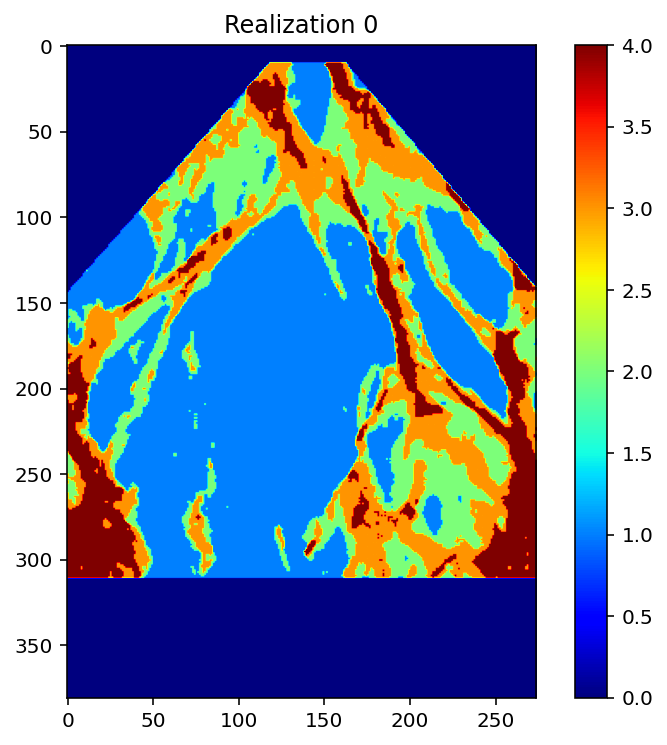

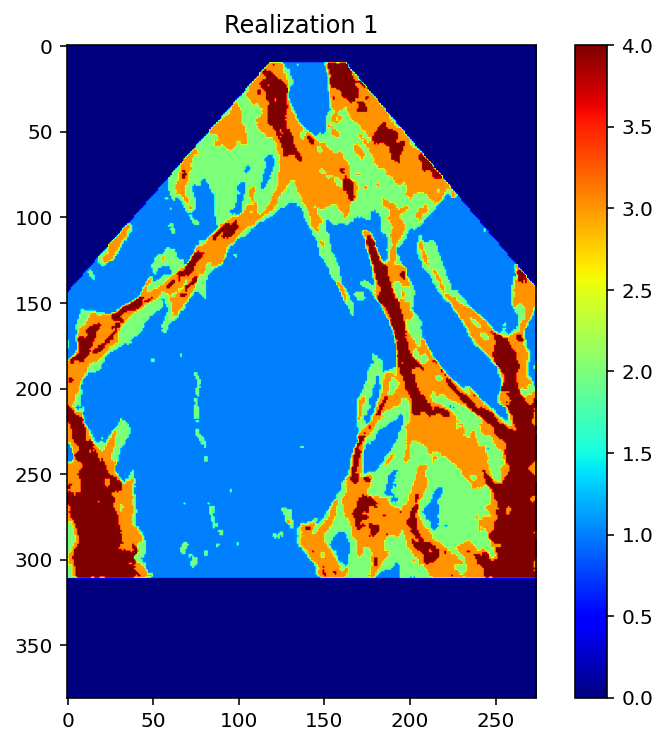

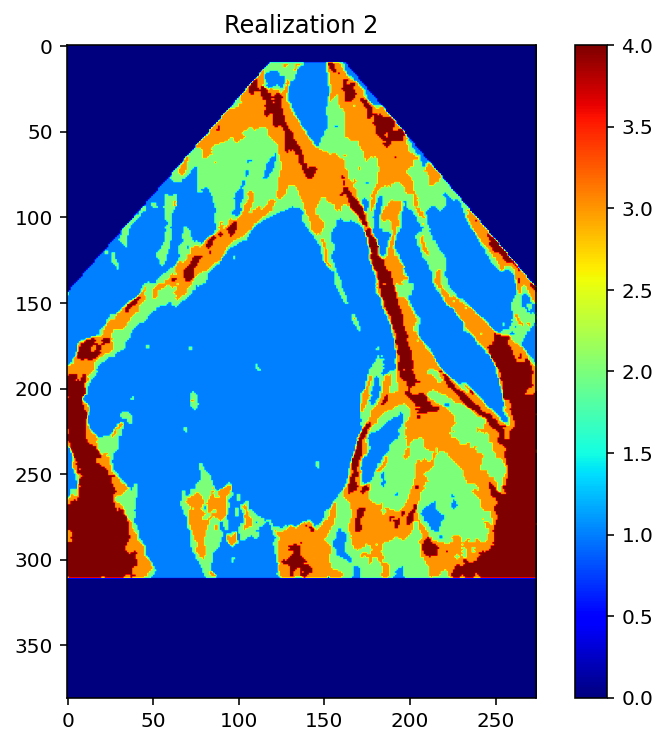

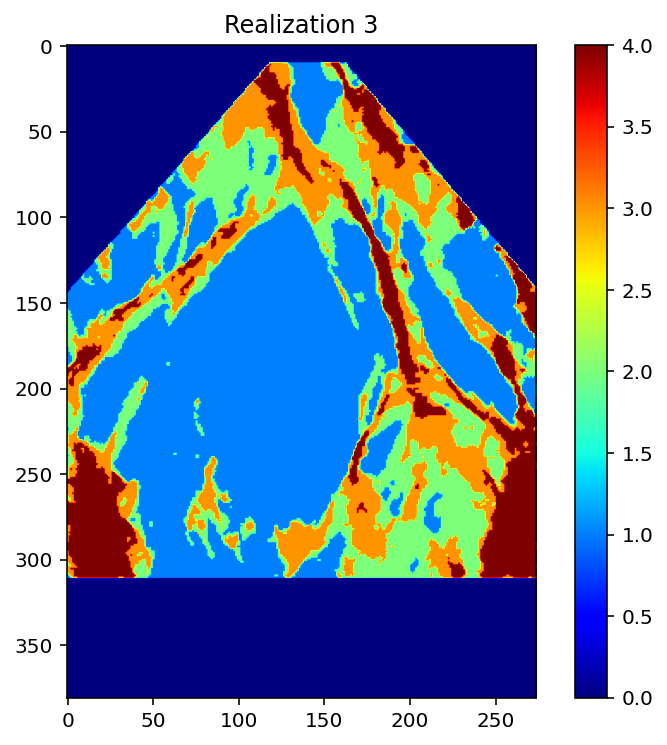

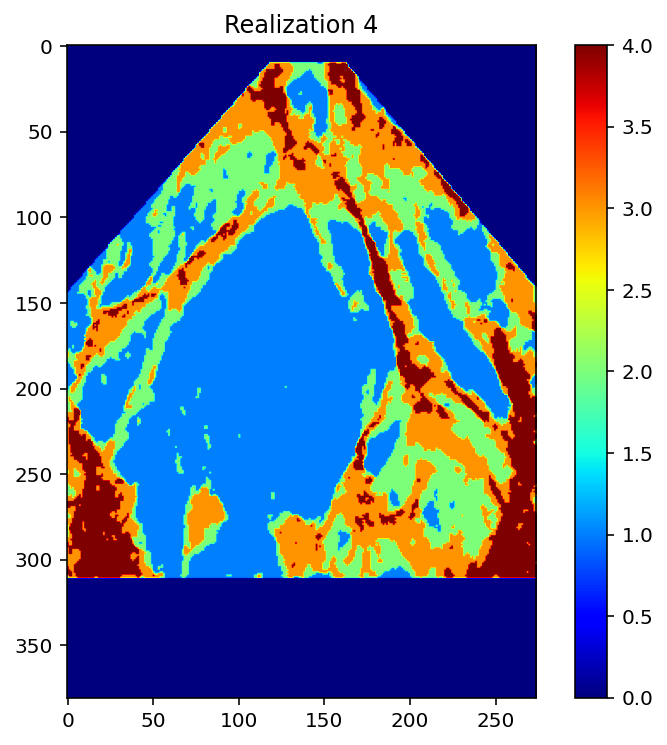

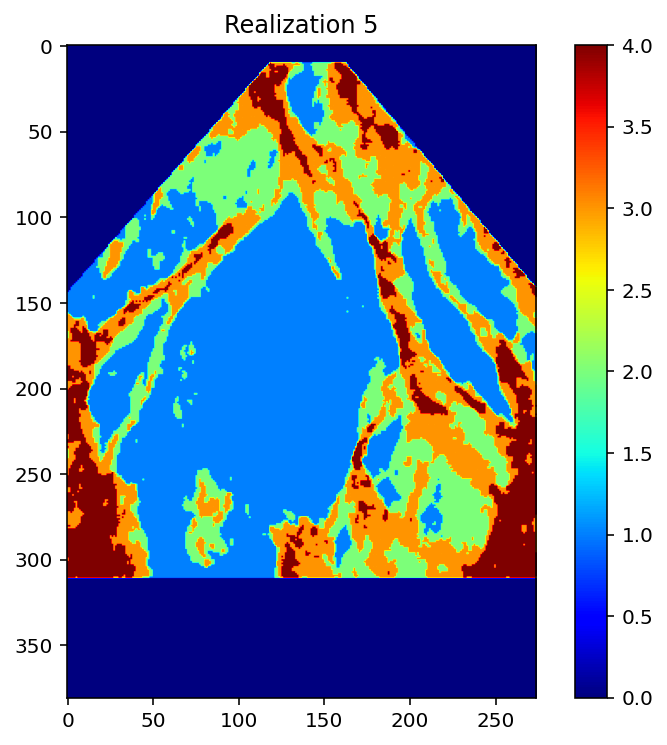

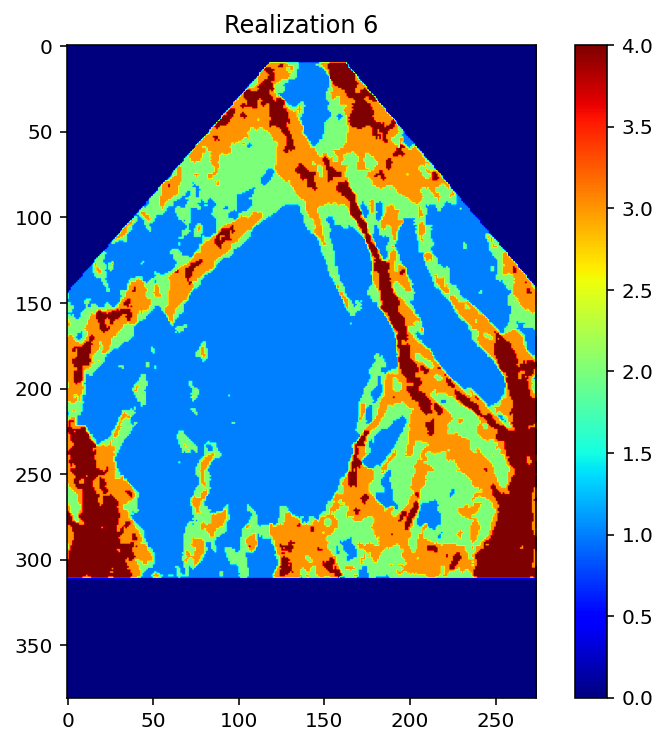

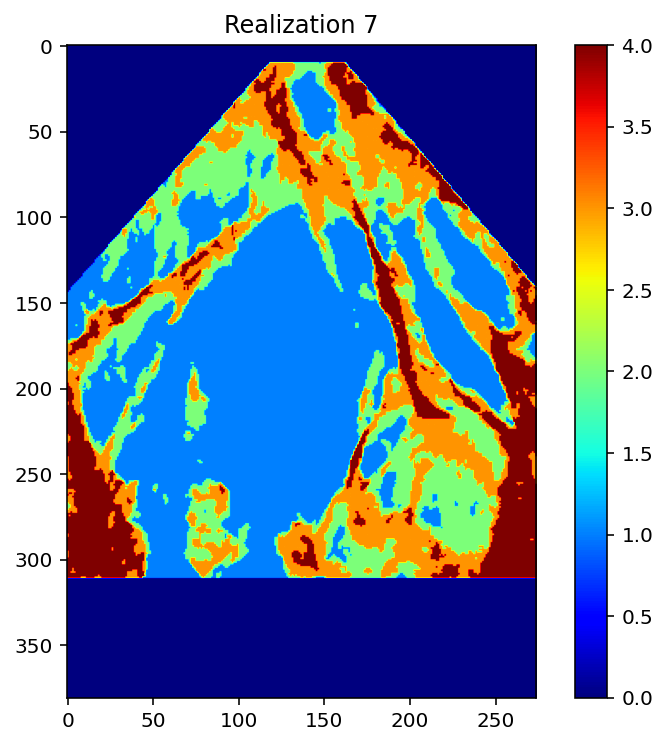

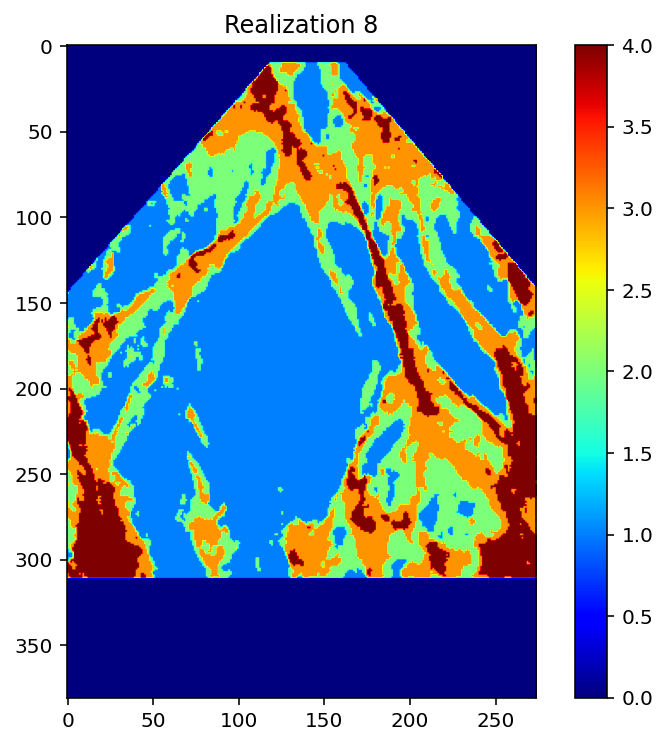

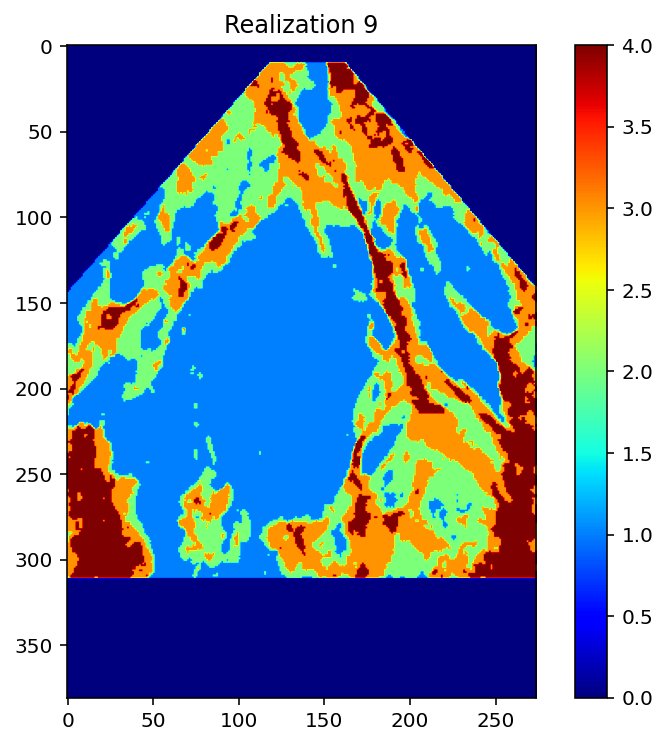

In [20]:
median_filter_template_size = 3

Realizations_Median = np.zeros((SimulationGrid_Num,
                                SimulationGrid_Height,
                                SimualtionGrid_Width))

for index_realization in range(SimulationGrid_Num):
    
    realization = np.copy(Realizations_FCNN_BallTree_TeacherStudent[index_realization])
    realization = ndimage.median_filter(realization, size = median_filter_template_size)
    
    Realizations_Median[index_realization] = np.copy(realization)
    
    plt.figure(figsize=(7,6))
    plt.imshow(realization, cmap='jet')
    plt.colorbar()
    plt.title(f'Realization {index_realization}')
    plt.show()

In [21]:
np.savetxt(fname='FlumeData_NNSIM_0.0_4categories.txt',
           X = Realizations_Median.reshape((1,-1)),
          fmt='%d',
          delimiter=',')